In [1]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import torch
import tqdm
import yaml
from attrdict import AttrDict
from torch.utils.data import DataLoader
import matplotlib.image as mpimg 

from modules.comp.comp_d_net_pl import *
from modules.mono.depth_net_pl import *
from modules.mv.mv_depth_net_pl import *
from utils.data_utils import *
from utils.localization_utils import *
#from utils.data_utils import TrajDataset_hge_customized_cropped

from src.helper_functions import *

/cluster/home/wueestm/anaconda3/envs/f3loc/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
net_type = "d"
#dataset = "gibson_t" # "gibson_g" # 
dataset = "hge_customized_cropped"

if dataset == "gibson_t":
    dataset_path = "/cluster/project/cvg/data/gibson/Gibson_Floorplan_Localization_Dataset"
    evol_path = "./evol_path/gibson_f/gt" #evol_path = "./evol_path/gibson_f/mono"
    orn_slice = 36
elif dataset == "hge_customized_cropped":
    dataset_path = "/cluster/project/cvg/data/lamar/HGE_customized_cropped"
    evol_path = "./evol_path/hge_customized_cropped/gt"
    desdf_resolution = 1.0
    orn_slice = 360  # number of discretized orientations

ckpt_path = "./logs"
traj_len = 100#15#100#50

In [3]:
# get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("======= USING DEVICE : ", device, " =======")

======= USING DEVICE :  cpu  =======


In [4]:
# paths
dataset_dir = os.path.join(dataset_path, dataset)
depth_dir = dataset_dir#args.dataset_path
log_dir = ckpt_path
desdf_path = os.path.join(dataset_path, "desdf")
evol_path = evol_path

In [5]:
# depth file suffix
if (net_type == "d") & (dataset == "hge_customized_cropped"):
    depth_suffix = "depth90"
elif net_type == "d":
    depth_suffix = "depth40"
else:
    depth_suffix = "depth160"

In [6]:
# instantiate dataset
traj_l = traj_len
split_file = os.path.join(dataset_dir, "split.yaml")
with open(split_file, "r") as f:
    split = AttrDict(yaml.safe_load(f))

if dataset == "hge_customized_cropped":
    test_set = TrajDataset_hge_customized_cropped(
        dataset_dir,
        split.test,
        L=traj_l,
        depth_dir=depth_dir,
        depth_suffix=depth_suffix,
        add_rp=False,
        roll=0,
        pitch=0,
        without_depth=False, #without_depth=True,  
    )

else:
    test_set = TrajDataset(
        dataset_dir,
        split.test,
        L=traj_l,
        depth_dir=depth_dir,
        depth_suffix=depth_suffix,
        add_rp=False,
        roll=0,
        pitch=0,
        without_depth=False, #without_depth=True,  
    )  
    
    
    


In [7]:
# logs
log_error = True
log_timing = True
log_extended = True

In [8]:
# parameters
L = 3  # number of the source frames
D = 128  # number of the depth planes
d_min = 0.1  # minimum depth
d_max = 15.0  # maximum depth
d_hyp = -0.2  # depth transform (uniform sampling in d**d_hyp)
F_W = 3 / 8  # camera intrinsic, focal length / image width
trans_thresh = 0.005  # translation threshold (variance) if using comp_s

In [9]:
# models
if net_type == "mvd" or net_type == "comp_s":
    # instaciate model
    mv_net = mv_depth_net_pl.load_from_checkpoint(
        checkpoint_path=os.path.join(log_dir, "mv.ckpt"),
        D=D,
        d_min=d_min,
        d_max=d_max,
        d_hyp=d_hyp,
    ).to(device)
if net_type == "d" or net_type == "comp_s":
    # instaciate model
    d_net = depth_net_pl.load_from_checkpoint(
        checkpoint_path=os.path.join(log_dir, "mono.ckpt"),
        d_min=d_min,
        d_max=d_max,
        d_hyp=d_hyp,
        D=D,
    ).to(device)
if net_type == "comp":
    mv_net_pl = mv_depth_net_pl(D=D, d_hyp=d_hyp, F_W=F_W)
    mono_net_pl = depth_net_pl(d_min=d_min, d_max=d_max, d_hyp=d_hyp, D=D, F_W=F_W)
    comp_net = comp_d_net_pl.load_from_checkpoint(
        checkpoint_path=os.path.join(log_dir, "comp.ckpt"),
        mv_net=mv_net_pl.net,
        mono_net=mono_net_pl.encoder,
        L=L,
        d_min=d_min,
        d_max=d_max,
        d_hyp=d_hyp,
        D=D,
        F_W=F_W,
        use_pred=True,
    ).to(device)
    comp_net.eval()  # this is needed to disable batchnorm

/cluster/home/wueestm/anaconda3/envs/f3loc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/wueestm/anaconda3/envs/f3loc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# get desdf for the scene
print("load desdf ...")
desdfs = {}
for scene in tqdm.tqdm(test_set.scene_names):
    desdfs[scene] = np.load(
        os.path.join(desdf_path, scene, "desdf.npy"), allow_pickle=True
    ).item()
#    desdfs[scene]["desdf"][desdfs[scene]["desdf"] > 10] = 10  # truncate
print("desdf shape: ", desdfs[scene]["desdf"].shape)

load desdf ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


desdf shape:  (80, 74, 360)


In [11]:
if dataset == "hge_customized_cropped":

    # Correspondences for calibration
    floorplan_correspondences = np.array([[1516, 490.5], [1532, 2162], [350, 1515], [391, 135]])
    trajectory_correspondences = np.array([[-12.600, 10.103], [77.981, 9.882], [42.641, -54.348], [-33.099, -51.229]])

    # Test the transformation on the source points
    pts_src = trajectory_correspondences
    pts_dst = floorplan_correspondences
    affine_matrix = find_affine_transform(pts_src, pts_dst)
    transformed_pts = np.array([apply_affine_transformation(pt, affine_matrix) for pt in pts_src])
    pixel_per_meter = (affine_matrix[0,1] + affine_matrix[1,0]) / 2

    print("Affine transformation matrix:\n", affine_matrix)
    print("Destination points:\n", pts_dst)
    print("Transformed points:\n", transformed_pts)
    print("pixel_per_meter:", pixel_per_meter)




Affine transformation matrix:
 [[ 2.17114437e-01  1.82770027e+01  1.33427459e+03]
 [ 1.83530911e+01 -1.73803654e-01  7.28138788e+02]]
Destination points:
 [[1516.   490.5]
 [1532.  2162. ]
 [ 350.  1515. ]
 [ 391.   135. ]]
Transformed points:
 [[1516.19150279  495.13390132]
 [1531.81872801 2157.6136592 ]
 [ 350.21402267 1520.17882748]
 [ 390.77574653  129.57361201]]
pixel_per_meter: 18.31504689521109


In [12]:
# get the ground truth pose file
print("load poses and maps ...")
maps = {}
gt_poses = {}
for scene in tqdm.tqdm(test_set.scene_names):
    # load map
    occ = cv2.imread(os.path.join(dataset_dir, scene, "map.png"))[:, :, 0]
    maps[scene] = occ
    h = occ.shape[0]
    w = occ.shape[1]

    # single trajectory
    poses = np.zeros([0, 3], dtype=np.float32)
    # get poses
    poses_file = os.path.join(dataset_dir, scene, "poses.txt")

    # read poses
    with open(poses_file, "r") as f:
        poses_txt = [line.strip() for line in f.readlines()]

    traj_len = len(poses_txt)
    traj_len -= traj_len % traj_l
    for state_id in range(traj_len):

        if dataset == "hge_customized_cropped":
            # get pose
            pose_ls = poses_txt[state_id].split(" ")
            pose = np.array(pose_ls, dtype=np.float32)
            # world to map 
            (x,y), th = world_to_map(position_world=pose[:2], 
                                        orientation_world_rad=pose[2], 
                                        affine_matrix=affine_matrix, 
                                        floorplan_correspondences=floorplan_correspondences)
        else:
            # get pose
            pose = poses_txt[state_id].split(" ")
            x = float(pose[0])
            y = float(pose[1])
            th = float(pose[2])
            # from world coordinate to map coordinate
            x = x / 0.01 + w / 2
            y = y / 0.01 + h / 2

        poses = np.concatenate(
            (poses, np.expand_dims(np.array((x, y, th), dtype=np.float32), 0)),
            axis=0,
        )

    gt_poses[scene] = poses

load poses and maps ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.09it/s]


In [13]:
# original_resolution = 0.01
# desdf_resolution = 0.1
# resolution_ratio = desdf_resolution / original_resolution
# resolution_ratio

In [14]:
# original_resolution = 1/pixel_per_meter
# desdf_resolution = 1
# resolution_ratio = desdf_resolution / original_resolution
# resolution_ratio

length of test_set:  5


  0%|                                                                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

Before loading data
After loading data
t =  0
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  1
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  2
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  3
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  4
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  5
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  6
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  7
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  8
Before inference
Before localize
Before preparing metrics
Before preparing plots
Before transition
t =  9


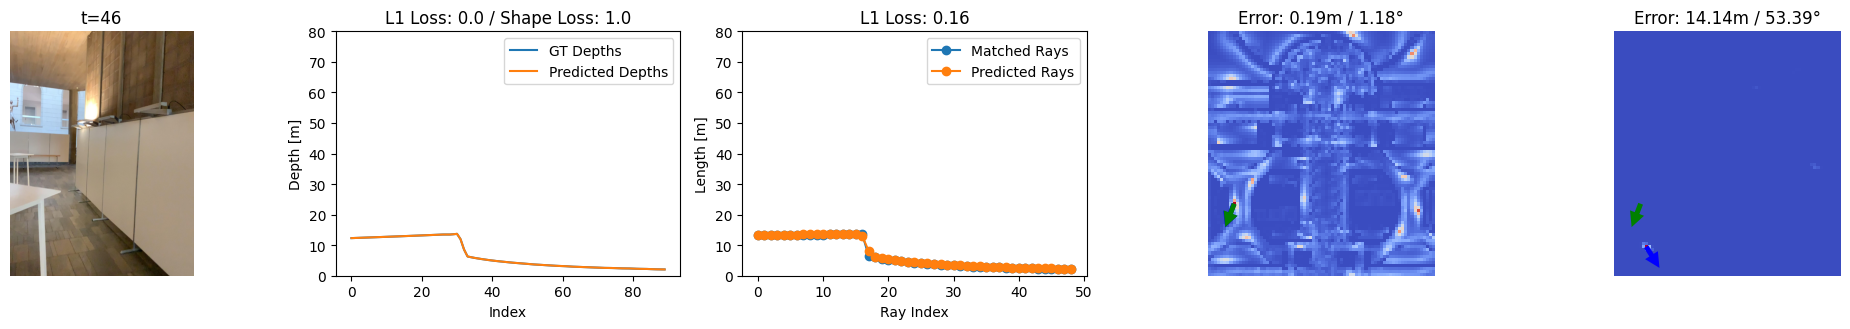

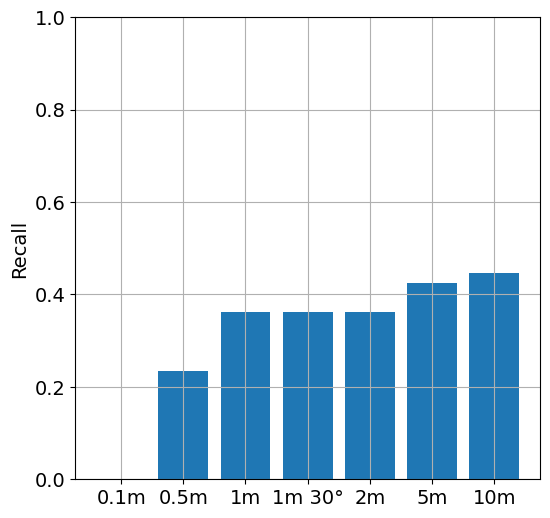

last_errors [10.493153 10.178598 10.608114 11.28369  12.041095 11.70411  12.391786
 11.972067 12.587389 14.174022]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:12<00:00, 612.12s/it]


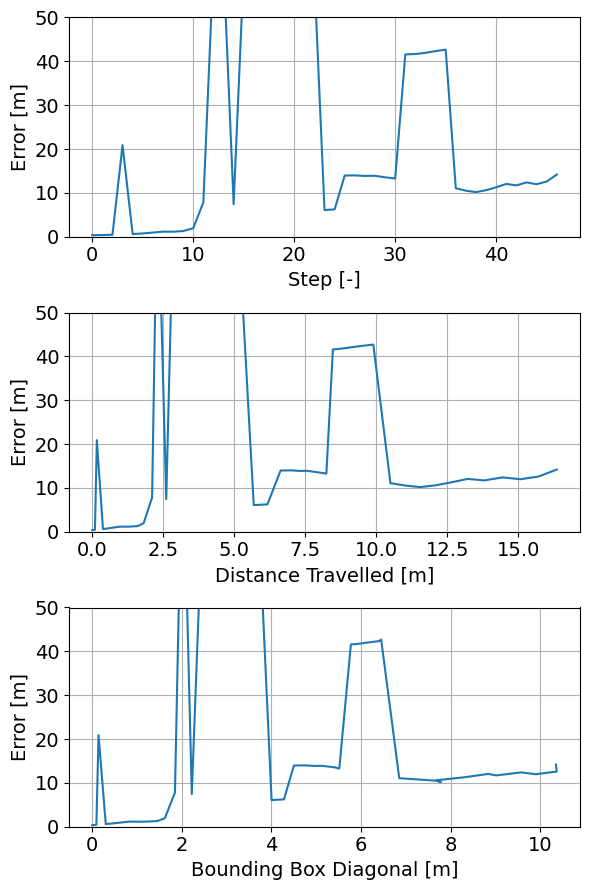

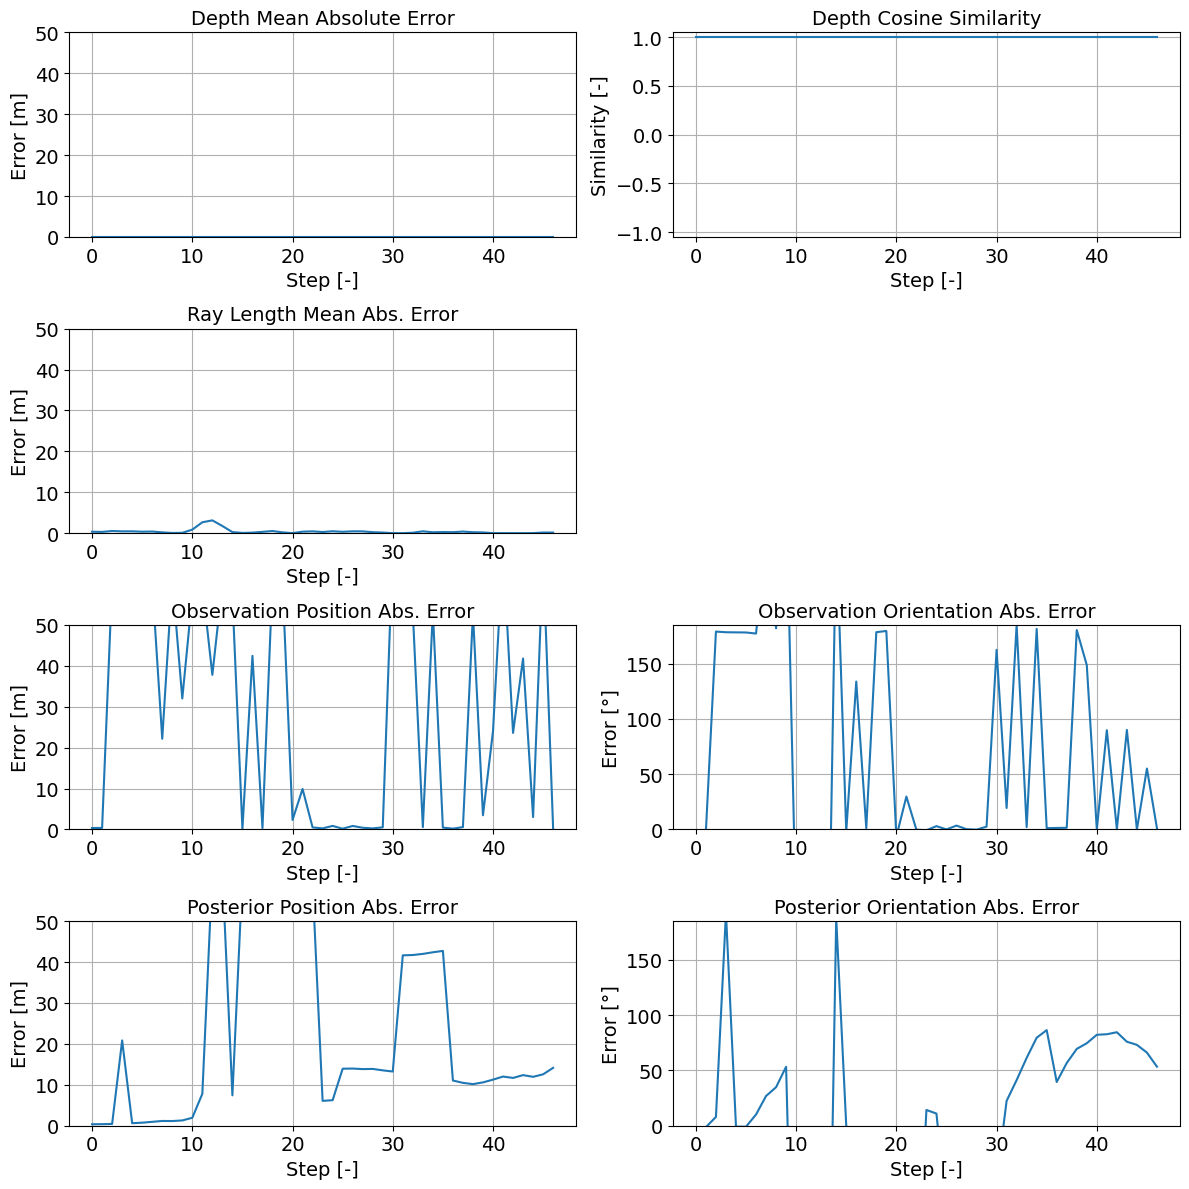

In [16]:
# record stats
RMSEs = []
success_10 = []  # Success @ 1m
success_5 = []  # Success @ 0.5m
success_3 = []  # Success @ 0.3m
success_2 = []  # Success @ 0.2m

matching_time = 0
iteration_time = 0
feature_extraction_time = 0
n_iter = 0

# loop the over scenes
print("length of test_set: ", len(test_set))
#for data_idx in tqdm.tqdm(range(36, len(test_set))):
for data_idx in tqdm.tqdm(range(1)):

    print("Before loading data")
    data = test_set[data_idx]
    print("After loading data")
    # get the scene name according to the data_idx
    scene_idx = np.sum(data_idx >= np.array(test_set.scene_start_idx)) - 1
    scene = test_set.scene_names[scene_idx]

    # get idx within scene
    idx_within_scene = data_idx - test_set.scene_start_idx[scene_idx]

    # get desdf
    desdf = desdfs[scene]

    # get reference pose in map coordinate and in scene coordinate
    poses_map = gt_poses[scene][
        idx_within_scene * traj_l : idx_within_scene * traj_l + traj_l, :
    ]

    # map to desdf 
    if dataset == "hge_customized_cropped":
        original_resolution = 1/pixel_per_meter
        resolution_ratio = desdf_resolution / original_resolution
        gt_pose_desdf = poses_map.copy()
        gt_pose_desdf[:, 0] = (gt_pose_desdf[:, 0] - desdf["l"]) / resolution_ratio
        gt_pose_desdf[:, 1] = (gt_pose_desdf[:, 1] - desdf["t"]) / resolution_ratio
        gt_pose_desdf[:, 2] = gt_pose_desdf[:, 2] 
    else:
        original_resolution = 0.01
        gt_pose_desdf = poses_map.copy()
        gt_pose_desdf[:, 0] = (gt_pose_desdf[:, 0] - desdf["l"]) / 10
        gt_pose_desdf[:, 1] = (gt_pose_desdf[:, 1] - desdf["t"]) / 10

    imgs = torch.tensor(data["imgs"], device=device).unsqueeze(0)
    poses = torch.tensor(data["poses"], device=device).unsqueeze(0)

    # set prior as uniform distribution
    prior = torch.tensor(
        np.ones_like(desdf["desdf"]) / desdf["desdf"].size, device=imgs.device
    ).to(torch.float32)

    pred_poses_map = []

    # record stats extended: per trajectory
    if (evol_path is not None) and (log_extended==True):
        metric_depth_l1_loss_ls = []
        metric_depth_shape_loss_ls = []
        metric_ray_l1_loss_ls = []
        metric_observation_position_err_ls = []
        metric_observation_orientation_err_ls = []
        metric_posterior_position_err_ls = []
        metric_posterior_orientation_err_ls = []

    # loop over the sequences
    for t in range(traj_l - L):
        print("t = ", t)
        start_iter = time.time()
        feature_extraction_start = time.time()
        # form input
        input_dict = {}
        if net_type == "mvd" or net_type == "comp" or net_type == "comp_s":
            input_dict.update(
                {
                    "ref_img": imgs[:, t + L, :, :, :],
                    "src_img": imgs[:, t : t + L, :, :, :],
                    "ref_pose": poses[:, t + L, :],
                    "src_pose": poses[:, t : t + L, :],
                    "ref_mask": None,  # no masks because the dataset has zero roll pitch
                    "src_mask": None,  # no masks because the dataset has zero roll pitch
                }
            )
        if net_type == "d" or net_type == "comp_s":
            input_dict.update(
                {
                    "img": imgs[:, t + L, :, :, :],
                    "mask": None,  # no masks because the dataset has zero roll pitch
                }
            )
        # check which model to use if hardcoded selection
        if net_type == "comp_s":
            # calculate the relative poses
            pose_var = (
                torch.cat(
                    (input_dict["ref_pose"].unsqueeze(1), input_dict["src_pose"]),
                    dim=1,
                )
                .squeeze(0)
                .var(dim=0)[:2]
                .sum()
            )
            if pose_var < trans_thresh:
                use_mv = False
                use_mono = True
            else:
                use_mv = True
                use_mono = False
        print("Before inference")
        # inference
        if net_type == "mvd" or (net_type == "comp_s" and use_mv):
            pred_dict = mv_net.net(input_dict)
            pred_depths = pred_dict["d"]
            pred_depths = pred_depths.squeeze(0).detach().cpu().numpy()
        elif net_type == "d" or (net_type == "comp_s" and use_mono):
            # ### Trained model:
            # pred_depths, attn_2d, prob = d_net.encoder(
            #     input_dict["img"], input_dict["mask"]
            # )
            # pred_depths = pred_depths.squeeze(0).detach().cpu().numpy()
            # ###

            ### GT:
            pred_depths = np.array(data["gt_depth"])[t + L,:]
            ###

            #print(type(pred_depths))
            #print(pred_depths.shape)
        elif net_type == "comp":
            pred_dict = comp_net.comp_d_net(input_dict)
            pred_depths = pred_dict["d_comp"]
            pred_depths = pred_depths.squeeze(0).detach().cpu().numpy()

        #pred_depths = pred_depths.squeeze(0).detach().cpu().numpy()

        # get rays from depth
        if dataset == "hge_customized_cropped":
            fov_desdf = 49#50
            dv = 360/orn_slice
            V = fov_desdf / dv
            pred_rays = get_ray_from_depth(pred_depths, V=V, dv=dv, F_W=1596/1440)
            pred_rays = torch.tensor(pred_rays, device=device)
        else:
            pred_rays = get_ray_from_depth(pred_depths)
            pred_rays = torch.tensor(pred_rays, device=device)

        feature_extraction_end = time.time()

        matching_start = time.time()
        print("Before localize")
        # use the prediction to localize, produce observation likelihood
        if dataset == "hge_customized_cropped":
            likelihood, likelihood_2d, likelihood_orn, likelihood_pred = localize_noflip(
                torch.tensor(desdf["desdf"]).to(prior.device),
                pred_rays.to(prior.device),
                return_np=False,
                orn_slice=orn_slice
            )
        else:
            likelihood, likelihood_2d, likelihood_orn, likelihood_pred = localize(
                torch.tensor(desdf["desdf"]).to(prior.device),
                pred_rays.to(prior.device),
                return_np=False,
                orn_slice=orn_slice
            )
            
        matching_end = time.time()

        # multiply with the prior
        posterior = prior * likelihood.to(prior.device)

        # reduce the posterior along orientation for 2d visualization
        posterior_2d, orientations = torch.max(posterior, dim=2)

        # compute prior_2d for visualization
        prior_2d, _ = torch.max(prior, dim=2)

        # maximum of the posterior as result
        pose_y, pose_x = torch.where(posterior_2d == posterior_2d.max())
        if pose_y.shape[0] > 1:
            pose_y = pose_y[0].unsqueeze(0)
            pose_x = pose_x[0].unsqueeze(0)
        orn = orientations[pose_y, pose_x]

        # from orientation indices to radians
        orn = orn / orn_slice * 2 * torch.pi
        pose = torch.cat((pose_x, pose_y, orn)).detach().cpu().numpy()

        if dataset == "hge_customized_cropped":
            pose_in_map = pose.copy()
            pose_in_map[0] = pose_in_map[0] * resolution_ratio + desdf["l"]
            pose_in_map[1] = pose_in_map[1] * resolution_ratio + desdf["t"]
        else:
            pose_in_map = pose.copy()
            pose_in_map[0] = pose_in_map[0] * 10 + desdf["l"]
            pose_in_map[1] = pose_in_map[1] * 10 + desdf["t"]

        pred_poses_map.append(pose_in_map)

        print("Before preparing metrics")
        if (evol_path is not None) & (log_extended==True):

            #### Prepare Metrics ------------------------------------------------

            ### Quality of depth prediction: Predicted depth vs. GT depth
            # Get variables
            predicted_depths = pred_depths
            gt_depths = np.array(data["gt_depth"])[t + L,:]
            # Get metrics
            metric_depth_l1_loss = F.l1_loss(torch.tensor(predicted_depths), torch.tensor(gt_depths)).item()
            metric_depth_shape_loss = F.cosine_similarity(torch.tensor(predicted_depths), torch.tensor(gt_depths), dim=-1).mean().item()

            ### Quality of matching: Matched ray vs. Predicted ray
            # Get variables
            idx_orn = int(likelihood_orn[likelihood_2d == likelihood_2d.max()][0])
            idx_x = int(likelihood_pred[1])
            idx_y = int(likelihood_pred[0])
            desdf_loc = torch.tensor(desdf["desdf"])
            V = pred_rays.shape[0]
            pad_front = V // 2
            pad_back = V - pad_front
            pad_desdf = F.pad(desdf_loc, [pad_front, pad_back], mode="circular")
            desdf_rays = pad_desdf[idx_x, idx_y, idx_orn: idx_orn + V]
            if dataset == "hge_customized_cropped":
                matched_rays = desdf_rays.cpu().numpy().copy()
            else:
                matched_rays = desdf_rays.cpu().numpy()[::-1].copy()  # move to CPU before converting to numpy
            predicted_rays = pred_rays.cpu().numpy()  # move pred_rays to CPU before converting to numpy
            # Get metrics
            metric_ray_l1_loss = F.l1_loss(torch.tensor(matched_rays), torch.tensor(predicted_rays)).item()


            ### Quality of localization per observation: Predicted pose vs. GT pose
            if dataset == "hge_customized_cropped":
                # Get variables
                observation_pose_in_map = np.empty(3)
                # desdf to map
                observation_pose_in_map[0] = likelihood_pred[0] * resolution_ratio + desdf["l"]
                observation_pose_in_map[1] = likelihood_pred[1] * resolution_ratio + desdf["t"]
                observation_pose_in_map[2] = likelihood_pred[2]
                # map to world
                observation_predicted_position, observation_predicted_orientation_rad = map_to_world(observation_pose_in_map[:2], observation_pose_in_map[2], affine_matrix, floorplan_correspondences)
                observation_predicted_orientation = observation_predicted_orientation_rad/np.pi*180
                gt_position, gt_orientation_rad = map_to_world(poses_map[t + L,:2], poses_map[t + L,2], affine_matrix, floorplan_correspondences)
                gt_orientation = gt_orientation_rad/np.pi*180
            else:
                # Get variables
                observation_pose_in_map = np.empty(3)
                # desdf to map
                observation_pose_in_map[0] = likelihood_pred[0] * 10 + desdf["l"]
                observation_pose_in_map[1] = likelihood_pred[1] * 10 + desdf["t"]
                observation_pose_in_map[2] = likelihood_pred[2]
                # map to world
                observation_predicted_position = observation_pose_in_map[:2]*0.01
                observation_predicted_orientation = observation_pose_in_map[2]/np.pi*180
                gt_position = poses_map[t + L,:2]*0.01
                gt_orientation = poses_map[t + L,2]/np.pi*180

            # Get metrics
            metric_observation_position_err = np.linalg.norm(observation_predicted_position - gt_position)
            metric_observation_orientation_err = observation_predicted_orientation - gt_orientation #min((observation_predicted_orientation - gt_orientation) % 360, 360 - ((observation_predicted_orientation - gt_orientation) % 360))

            ### Quality of localization filter: Predicted posterior pose vs. GT pose
            if dataset == "hge_customized_cropped":
                # Get variables
                # map to world
                posterior_predicted_position, posterior_predicted_orientation_rad = map_to_world(pose_in_map[:2], pose_in_map[2], affine_matrix, floorplan_correspondences)
                posterior_predicted_orientation = posterior_predicted_orientation_rad/np.pi*180
                gt_position, gt_orientation_rad = map_to_world(poses_map[t + L,:2], poses_map[t + L,2], affine_matrix, floorplan_correspondences)
                gt_orientation = gt_orientation_rad/np.pi*180
            else:
                # Get variables
                # map to world
                posterior_predicted_position = pose_in_map[:2]*0.01
                posterior_predicted_orientation = pose_in_map[2]/np.pi*180
                gt_position = poses_map[t + L,:2]*0.01
                gt_orientation = poses_map[t + L,2]/np.pi*180

            # Get metrics
            metric_posterior_position_err = np.linalg.norm(posterior_predicted_position - gt_position)
            metric_posterior_orientation_err = posterior_predicted_orientation - gt_orientation #min((posterior_predicted_orientation - gt_orientation) % 360, 360 - (posterior_predicted_orientation - gt_orientation) % 360)


            ### Log metrics
            metric_depth_l1_loss_ls.append(metric_depth_l1_loss)
            metric_depth_shape_loss_ls.append(metric_depth_shape_loss)
            metric_ray_l1_loss_ls.append(metric_ray_l1_loss)
            metric_observation_position_err_ls.append(metric_observation_position_err)
            metric_observation_orientation_err_ls.append(metric_observation_orientation_err)
            metric_posterior_position_err_ls.append(metric_posterior_position_err)
            metric_posterior_orientation_err_ls.append(metric_posterior_orientation_err)


            #### Plot Figure ------------------------------------------------
            print("Before preparing plots")
            fig = plt.figure(1, figsize=(4*5, 3.4))
            fig.clf()

            ### Image
            ax = fig.add_subplot(1, 5, 1)
            if dataset == "hge_customized_cropped":
                img_path = os.path.join(dataset_dir, scene, "rgb", '{:05d}'.format((idx_within_scene * traj_l) + (t + L)) + "-0.jpg")
            else:
                img_path = os.path.join(dataset_dir, scene, "rgb", '{:05d}'.format((idx_within_scene * traj_l) + (t + L)) + ".png")
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title("t=" + str(t))

            ### Quality of depth prediction: Predicted depth vs. GT depth
            ax = fig.add_subplot(1, 5, 2)
            ax.plot(gt_depths, label="GT Depths")
            ax.plot(predicted_depths, label="Predicted Depths")
            ax.set_title("L1 Loss: " + str(np.round(metric_depth_l1_loss, 2)) + " / Shape Loss: " + str(np.round(metric_depth_shape_loss,2)))
            ax.legend()
            ax.set_xlabel("Index")
            ax.set_ylabel("Depth [m]")
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,80])  
            else:
                ax.set_ylim([0,10])


            ### Quality of matching: Matched ray vs. Predicted ray
            ax = fig.add_subplot(1, 5, 3)
            ax.plot(matched_rays, label="Matched Rays", marker='o')
            ax.plot(predicted_rays, label="Predicted Rays", marker='o')
            ax.set_title("L1 Loss: " + str(np.round(metric_ray_l1_loss, 2)))
            ax.legend()
            ax.set_xlabel("Ray Index")
            ax.set_ylabel("Length [m]")
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,80])  
            else:
                ax.set_ylim([0,10])


            ### Quality of localization per observation: Predicted pose vs. GT pose
            s = 0.25
            ax = fig.add_subplot(1, 5, 4)
            if dataset == "hge_customized_cropped":
                ax.imshow(likelihood_2d, cmap="coolwarm")
            else:
                ax.imshow(likelihood_2d, origin="lower", cmap="coolwarm")
            ax.set_title("Error: " + str(np.round(metric_observation_position_err,2)) + "m / " + str(np.round(metric_observation_orientation_err,2)) + "°")
            ax.axis("off")
            ax.quiver(
                likelihood_pred[0],
                likelihood_pred[1],
                s*np.cos(likelihood_pred[2]),
                s*np.sin(likelihood_pred[2]),
                color="blue",
                width=s*0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=s*0.1,
                angles = "xy"
            )
            ax.quiver(
                gt_pose_desdf[t + L, 0],
                gt_pose_desdf[t + L, 1],
                s*np.cos(gt_pose_desdf[t + L, 2]),
                s*np.sin(gt_pose_desdf[t + L, 2]),
                color="green",
                width=s*0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=s*0.1,
                angles = "xy"
            )

            ### Quality of localization per observation: Predicted pose vs. GT pose
            ax = fig.add_subplot(1, 5, 5)
            if dataset == "hge_customized_cropped":
                ax.imshow(posterior_2d.detach().cpu().numpy(), cmap="coolwarm")
            else:
                ax.imshow(posterior_2d.detach().cpu().numpy(), origin="lower", cmap="coolwarm")
            ax.set_title("Error: " + str(np.round(metric_posterior_position_err,2)) + "m / " + str(np.round(metric_posterior_orientation_err,2)) + "°")
            ax.axis("off")
            ax.quiver(
                pose[0],
                pose[1],
                s*np.cos(pose[2]),
                s*np.sin(pose[2]),
                color="blue",
                width=s*0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=s*0.1,
                angles = "xy"
            )
            ax.quiver(
                gt_pose_desdf[t + L, 0],
                gt_pose_desdf[t + L, 1],
                s*np.cos(gt_pose_desdf[t + L, 2]),
                s*np.sin(gt_pose_desdf[t + L, 2]),
                color="green",
                width=s*0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=s*0.1,
                angles = "xy"
            )
            plt.tight_layout()

            if not os.path.exists(
                os.path.join(evol_path, "pretty_filter_extended", str(data_idx))
            ):
                os.makedirs(os.path.join(evol_path, "pretty_filter_extended", str(data_idx)))
            fig.savefig(
                os.path.join(
                    evol_path, "pretty_filter_extended", str(data_idx), str(t) + ".png"
                )
            )

        elif (evol_path is not None) & (log_extended==False):
            # plot posterior 2d
            fig = plt.figure(0, figsize=(20, 20))
            fig.clf()
            ax = fig.add_subplot(1, 2, 2)
            ax.imshow(
                posterior_2d.detach().cpu().numpy(), origin="lower", cmap="coolwarm"
            )
            ax.quiver(
                pose[0],
                pose[1],
                np.cos(pose[2]),
                np.sin(pose[2]),
                color="blue",
                width=0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=0.1,
            )
            ax.quiver(
                gt_pose_desdf[t + L, 0],
                gt_pose_desdf[t + L, 1],
                np.cos(gt_pose_desdf[t + L, 2]),
                np.sin(gt_pose_desdf[t + L, 2]),
                color="green",
                width=0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=0.1,
            )
            ax.axis("off")
            ax.set_title(str(t) + " posterior")

            ax = fig.add_subplot(1, 2, 1)
            ax.imshow(likelihood_2d, origin="lower", cmap="coolwarm")
            ax.set_title(str(t) + " likelihood")
            ax.axis("off")
            ax.quiver(
                likelihood_pred[0],
                likelihood_pred[1],
                np.cos(likelihood_pred[2]),
                np.sin(likelihood_pred[2]),
                color="blue",
                width=0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=0.1,
            )
            ax.quiver(
                gt_pose_desdf[t + L, 0],
                gt_pose_desdf[t + L, 1],
                np.cos(gt_pose_desdf[t + L, 2]),
                np.sin(gt_pose_desdf[t + L, 2]),
                color="green",
                width=0.2,
                scale_units="inches",
                units="inches",
                scale=1,
                headwidth=3,
                headlength=3,
                headaxislength=3,
                minlength=0.1,
            )

            if not os.path.exists(
                os.path.join(evol_path, "pretty_filter", str(data_idx))
            ):
                os.makedirs(os.path.join(evol_path, "pretty_filter", str(data_idx)))
            fig.savefig(
                os.path.join(
                    evol_path, "pretty_filter", str(data_idx), str(t) + ".png"
                )
            )

        print("Before transition")
        # transition
        # use ground truth to compute transitions, use relative poses
        if t + L == traj_l - 1:
            continue

        if dataset == "hge_customized_cropped":
            current_pose_desdf = torch.from_numpy(gt_pose_desdf[t + L, :])
            next_pose_desdf = torch.from_numpy(gt_pose_desdf[t + L + 1, :])
            transition = get_rel_pose(current_pose_desdf, next_pose_desdf)
            prior = transit(
                posterior, transition, sig_o=0.1, sig_x=0.1, sig_y=0.1, tsize=7, rsize=7, resolution=1
            )
        else:
            current_pose = poses[0, t + L, :]
            next_pose = poses[0, t + L + 1, :]

            transition = get_rel_pose(current_pose, next_pose)
            prior = transit(
                posterior, transition, sig_o=0.1, sig_x=0.1, sig_y=0.1, tsize=7, rsize=7
            )

        end_iter = time.time()
        matching_time += matching_end - matching_start
        feature_extraction_time += feature_extraction_end - feature_extraction_start
        iteration_time += end_iter - start_iter
        n_iter += 1

    # Evaluate quality of localization per observation
    if (evol_path is not None) and (log_extended==True):
        acc_record = np.array(metric_observation_position_err_ls)
        acc_orn_record = np.array(metric_observation_orientation_err_ls)

        
        # Calculate recalls
        recall_10m = np.sum(acc_record < 10) / acc_record.shape[0]
        recall_5m = np.sum(acc_record < 5) / acc_record.shape[0]
        recall_2m = np.sum(acc_record < 2) / acc_record.shape[0]
        recall_1m = np.sum(acc_record < 1) / acc_record.shape[0]
        recall_0_5m = np.sum(acc_record < 0.5) / acc_record.shape[0]
        recall_0_1m = np.sum(acc_record < 0.1) / acc_record.shape[0]
        recall_1m_30deg = np.sum(np.logical_and(acc_record < 1, acc_orn_record < 30)) / acc_record.shape[0]

        # Print recalls
        print("10m recall = ", recall_10m)
        print("5m recall = ", recall_5m)
        print("2m recall = ", recall_2m)
        print("1m recall = ", recall_1m)
        print("0.5m recall = ", recall_0_5m)
        print("0.1m recall = ", recall_0_1m)
        print("1m 30 deg recall = ", recall_1m_30deg)

        # Plot bar plot of recalls
        recalls = [recall_0_1m, recall_0_5m, recall_1m, recall_1m_30deg, recall_2m, recall_5m, recall_10m]
        labels = ['0.1m', '0.5m', '1m', '1m 30°', '2m', '5m', '10m']
        fig = plt.figure(3, figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(labels, recalls)
        #ax.set_xlabel('Recall Type', fontsize=14)
        ax.set_ylabel('Recall', fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim([0, 1])
        ax.grid(True)
        plt.show()
        fig.savefig(os.path.join(evol_path, "pretty_filter_extended", str(data_idx), "recalls" + ".png"))




    if (evol_path is not None) and (log_extended==True):
        
        pred_poses_map = np.stack(pred_poses_map)

        ## Error
        error = (
            ((pred_poses_map[-(traj_l - L):, :2] - poses_map[-(traj_l - L):, :2]) ** 2).sum(axis=1)
            ** 0.5
        ) * original_resolution


        ## Bounding Box Diagonal
        # Calculate bounding box diagonal for each step
        bounding_box_diagonals = []
        for i in range(1, len(poses_map[-(traj_l - L):, :2]) + 1):
            current_positions = poses_map[-(traj_l - L):, :2][:i]
            diagonal_length = minimum_bounding_box(current_positions) * original_resolution
            bounding_box_diagonals.append(diagonal_length)
        bounding_box_diagonal = np.array(bounding_box_diagonals)


        ## Distance Travelled
        # Calculate the differences between each consecutive pair of positions
        differences = np.diff(poses_map[-(traj_l - L):, :2], axis=0)
        # Calculate the Euclidean distance for each pair
        distances = np.sqrt((differences ** 2).sum(axis=1))* original_resolution
        # Calculate the accumulated distance for each timestamp
        distance_travelled = np.concatenate(([0], np.cumsum(distances)))

        ## Plot Error vs. Distance Travelled
        fig = plt.figure(4, figsize=(6, 9))
        fig.clf()
        ax = fig.add_subplot(3, 1, 1)
        ax.plot(error)
        ax.grid()
        ax.set_xlabel("Step [-]", fontsize=14)
        ax.set_ylabel("Error [m]", fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14) 
        if dataset == "hge_customized_cropped":
            ax.set_ylim([0,50])  
        else:
            ax.set_ylim([0,5])
        ax = fig.add_subplot(3, 1, 2)
        ax.plot(distance_travelled, error)
        ax.grid()
        ax.set_xlabel("Distance Travelled [m]", fontsize=14)
        ax.set_ylabel("Error [m]", fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if dataset == "hge_customized_cropped":
            ax.set_ylim([0,50])  
        else:
            ax.set_ylim([0,5])
        ax = fig.add_subplot(3, 1, 3)
        ax.plot(bounding_box_diagonal, error)
        ax.grid()
        ax.set_xlabel("Bounding Box Diagonal [m]", fontsize=14)
        ax.set_ylabel("Error [m]", fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if dataset == "hge_customized_cropped":
            ax.set_ylim([0,50])
        else:
            ax.set_ylim([0,5])
        fig.tight_layout()

        if not os.path.exists(os.path.join(evol_path, "pretty_filter_extended", str(data_idx))):
            os.makedirs(os.path.join(evol_path, "pretty_filter_extended", str(data_idx)))
        fig.savefig(os.path.join(evol_path, "pretty_filter_extended", str(data_idx), "error_evolution" + ".png"))



    if (evol_path is not None) and (log_extended==True):    
            fig = plt.figure(5, figsize=(2*6, 4*3))
            
            ax = fig.add_subplot(4, 2, 1)
            ax.plot(metric_depth_l1_loss_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [m]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14) 
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,50])
            else:
                ax.set_ylim([0,5])
            ax.set_title("Depth Mean Absolute Error", fontsize=14)

            ax = fig.add_subplot(4, 2, 2)
            ax.plot(metric_depth_shape_loss_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Similarity [-]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_ylim([-1.05, 1.05])
            ax.set_title("Depth Cosine Similarity", fontsize=14)

            ax = fig.add_subplot(4, 2, 3)
            ax.plot(metric_ray_l1_loss_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [m]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,50])
            else:
                ax.set_ylim([0,5])
            ax.set_title("Ray Length Mean Abs. Error", fontsize=14)

            # Create an empty and invisible subplot at position (4, 2, 4)
            ax = fig.add_subplot(4, 2, 4)
            ax.axis('off')  # Turn off the axis for this subplot

            ax = fig.add_subplot(4, 2, 5)
            ax.plot(metric_observation_position_err_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [m]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,50])
            else:
                ax.set_ylim([0,5])
            ax.set_title("Observation Position Abs. Error", fontsize=14)

            ax = fig.add_subplot(4, 2, 6)
            ax.plot(metric_observation_orientation_err_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [°]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_ylim([0, 185])
            ax.set_title("Observation Orientation Abs. Error", fontsize=14)

            ax = fig.add_subplot(4, 2, 7)
            ax.plot(metric_posterior_position_err_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [m]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            if dataset == "hge_customized_cropped":
                ax.set_ylim([0,50])
            else:
                ax.set_ylim([0,5])
            ax.set_title("Posterior Position Abs. Error", fontsize=14)

            ax = fig.add_subplot(4, 2, 8)
            ax.plot(metric_posterior_orientation_err_ls)
            ax.grid()
            ax.set_xlabel("Step [-]", fontsize=14)
            ax.set_ylabel("Error [°]", fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_ylim([0, 185])
            ax.set_title("Posterior Orientation Abs. Error", fontsize=14)
            fig.tight_layout()

            if not os.path.exists(os.path.join(evol_path, "pretty_filter_extended", str(data_idx))):
                os.makedirs(os.path.join(evol_path, "pretty_filter_extended", str(data_idx)))
            fig.savefig(os.path.join(evol_path, "pretty_filter_extended", str(data_idx), "metrics" + ".png"))

    if log_error:
        pred_poses_map = np.stack(pred_poses_map)
        # record success rate, from map to global
        last_errors = (
            ((pred_poses_map[-10:, :2] - poses_map[-10:, :2]) ** 2).sum(axis=1)
            ** 0.5
        ) * original_resolution
        # compute RMSE
        RMSE = (
            ((pred_poses_map[-10:, :2] - poses_map[-10:, :2]) ** 2)
            .sum(axis=1)
            .mean()
        ) ** 0.5 * original_resolution
        RMSEs.append(RMSE)
        print("last_errors", last_errors)
        if all(last_errors < 1):
            success_10.append(True)
        else:
            success_10.append(False)

        if all(last_errors < 0.5):
            success_5.append(True)
        else:
            success_5.append(False)

        if all(last_errors < 0.3):
            success_3.append(True)
        else:
            success_3.append(False)

        if all(last_errors < 0.2):
            success_2.append(True)
        else:
            success_2.append(False)


In [ ]:
if log_error:
    RMSEs = np.array(RMSEs)
    success_10 = np.array(success_10)
    success_5 = np.array(success_5)
    success_3 = np.array(success_3)
    success_2 = np.array(success_2)

    print("============================================")
    print("1.0 success rate : ", success_10.sum() / len(test_set))
    print("0.5 success rate : ", success_5.sum() / len(test_set))
    print("0.3 success rate : ", success_3.sum() / len(test_set))
    print("0.2 success rate : ", success_2.sum() / len(test_set))
    print("mean RMSE succeeded : ", RMSEs[success_10].mean())
    print("mean RMSE all : ", RMSEs.mean())


In [ ]:
if log_timing:
    feature_extraction_time = feature_extraction_time / n_iter
    matching_time = matching_time / n_iter
    iteration_time = iteration_time / n_iter

    print("============================================")
    print("feature_extraction_time : ", feature_extraction_time)
    print("matching_time : ", matching_time)
    print("iteration_time : ", iteration_time)
    

In [ ]:
import imageio
import os
#import pillow
#import imageio-ffmpeg
import imageio


def extract_number(filename):
    try:
        # Assuming the filename format is something like 'plot_123.png'
        return int(filename.split('-')[-1].split('.')[0])
    except (IndexError, ValueError) as e:
        print(f"Error parsing filename: {filename}")
        return -1  # Return a default value in case of error


### Create GIF
#for data_idx in tqdm.tqdm(range(len(test_set))):
#for data_idx in tqdm.tqdm(range(2)):


data_idx = 0

image_folder = os.path.join(evol_path, "pretty_filter_extended", str(data_idx))
gif_path = os.path.join(image_folder, "animation.gif")

# List of image filenames, sorted by the number in their name
image_files = [img for img in os.listdir(image_folder) if img.endswith(".png")]

# Debug: Print the image filenames to inspect their format
print("Image files found:", image_files)

# Sort the images based on the extracted number
images = sorted(image_files, key=extract_number)

# Read images into a list
image_list = []
for filename in images:
    image_path = os.path.join(image_folder, filename)
    image_list.append(imageio.imread(image_path))

# Create a GIF from the list of images
imageio.mimsave(gif_path, image_list, duration=250)  # Adjust duration as needed

print(f"GIF saved to {gif_path}")



In [ ]:
import imageio
import os
import tqdm
from PIL import Image
import numpy as np

def extract_number(filename):
    try:
        return int(filename.split('.')[0])
    except (IndexError, ValueError):
        return -1  # Return a default value in case of error

def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

### Create GIF
#for data_idx in tqdm.tqdm(range(len(test_set))):
for data_idx in tqdm.tqdm(range(2)):
    image_folder = os.path.join(evol_path, "pretty_filter_extended", str(data_idx))
    gif_path = os.path.join(image_folder, 'animation.gif')  # Specify the full path for the output GIF file

    # List of image filenames, sorted by the number in their name
    image_files = [img for img in os.listdir(image_folder) if img.endswith(".png") and extract_number(img) != -1]

    # Debug: Print the image filenames to inspect their format
    print("Image files found:", image_files)

    # Sort the images based on the extracted number
    images = sorted(image_files, key=extract_number)

    # Read images into a list
    image_list = []
    target_size = None
    for filename in images:
        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)
            if target_size is None:
                target_size = image.size  # Set the target size to the size of the first image
            image = resize_image(image, target_size)
            image_list.append(np.array(image))
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")

    # Create a GIF from the list of images
    imageio.mimsave(gif_path, image_list, duration=250)  # Adjust duration as needed

    print(f"GIF saved to {gif_path}")


In [ ]:
import imageio
import os
import tqdm
from PIL import Image
import numpy as np

def extract_number(filename):
    try:
        return int(filename.split('.')[0])
    except (IndexError, ValueError):
        return -1  # Return a default value in case of error

def resize_image(image, size):
    return image.resize(size, Image.Resampling.LANCZOS)

evol_path = "./evol_path/gibson_f/mono"


### Create GIF
#for data_idx in tqdm.tqdm(range(len(test_set))):
for data_idx in tqdm.tqdm(range(37)):
    image_folder = os.path.join(evol_path, "pretty_filter_extended", str(data_idx))
    gif_path = os.path.join(image_folder, 'animation.gif')  # Specify the full path for the output GIF file

    # List of image filenames, sorted by the number in their name
    image_files = [img for img in os.listdir(image_folder) if img.endswith(".png") and extract_number(img) != -1]

    # Debug: Print the image filenames to inspect their format
    print("Image files found:", image_files)

    # Sort the images based on the extracted number
    images = sorted(image_files, key=extract_number)

    # Read images into a list
    image_list = []
    target_size = None
    for filename in images:
        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)
            if target_size is None:
                target_size = image.size  # Set the target size to the size of the first image
                print(f"Target size set to: {target_size}")
            image = resize_image(image, target_size)
            image_list.append(np.array(image))
            print(f"Loaded image: {filename}")
        except Exception as e:
            print(f"Error reading image {image_path}: {e}")

    # Check if image_list is empty
    if not image_list:
        print("No valid images were loaded. Exiting.")
        continue

    # Create a GIF from the list of images
    imageio.mimsave(gif_path, image_list, duration=1000)  # Adjust duration as needed

    print(f"GIF saved to {gif_path}")


### TESTBED

In [ ]:

pred_poses_map = np.stack(pred_poses_map)

## Error
error = (
    ((pred_poses_map[-(traj_l - L):, :2] - poses_map[-(traj_l - L):, :2]) ** 2).sum(axis=1)
    ** 0.5
) * 0.01


## Bounding Box Diagonal
# Calculate bounding box diagonal for each step
bounding_box_diagonals = []
for i in range(1, len(poses_map[-(traj_l - L):, :2]) + 1):
    current_positions = poses_map[-(traj_l - L):, :2][:i]
    diagonal_length = minimum_bounding_box(current_positions) * 0.01
    bounding_box_diagonals.append(diagonal_length)
bounding_box_diagonal = np.array(bounding_box_diagonals)


## Distance Travelled
# Calculate the differences between each consecutive pair of positions
differences = np.diff(poses_map[-(traj_l - L):, :2], axis=0)
# Calculate the Euclidean distance for each pair
distances = np.sqrt((differences ** 2).sum(axis=1))* 0.01
# Calculate the accumulated distance for each timestamp
distance_travelled = np.concatenate(([0], np.cumsum(distances)))


## Plot Error vs. Distance Travelled
fig = plt.figure(3, figsize=(6, 9))
fig.clf()
ax = fig.add_subplot(3, 1, 1)
print("here 1")
ax.plot(error)
ax.grid()
ax.set_xlabel("Step [-]", fontsize=14)
ax.set_ylabel("Error [m]", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14) 
ax.set_ylim([0,5])
print("here 1")
ax = fig.add_subplot(3, 1, 2)
ax.plot(distance_travelled, error)
ax.grid()
ax.set_xlabel("Distance Travelled [m]", fontsize=14)
ax.set_ylabel("Error [m]", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
if dataset == "hge_customized_cropped":
    ax.set_ylim([0,5])  
else:
    ax.set_ylim([0,50])
ax = fig.add_subplot(3, 1, 3)
ax.plot(bounding_box_diagonal, error)
ax.grid()
ax.set_xlabel("Distance Travelled [m]", fontsize=14)
ax.set_ylabel("Error [m]", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
if dataset == "hge_customized_cropped":
    ax.set_ylim([0,5])  
else:
    ax.set_ylim([0,50])
fig.tight_layout()

In [ ]:
# Example usage
points = np.random.rand(30, 2)  # Replace this with your trajectory points

# Calculate the minimum bounding box
bbox_points, bbox_area = minimum_bounding_box(points)

# Plot the points and the bounding box
print("bbox_area: ", bbox_area)
print("bbox_points: ", bbox_points)
plt.scatter(points[:, 0], points[:, 1], label='Points')
plt.plot(*np.append(bbox_points, [bbox_points[0]], axis=0).T, 'r-', label='Bounding Box')
plt.legend()
plt.show()


In [ ]:
###

In [ ]:
### Quality of depth prediction: Predicted depth vs. GT depth

# Get variables
predicted_depths = pred_depths
gt_depths = np.array(data["gt_depth"])[t + L,:]
print(predicted_depths)
print(gt_depths)

# Get metrics
metric_depth_l1_loss = F.l1_loss(torch.tensor(predicted_depths), torch.tensor(gt_depths)).item()
print(metric_depth_l1_loss)

metric_depth_shape_loss = F.cosine_similarity(torch.tensor(predicted_depths), torch.tensor(gt_depths), dim=-1).mean().item()
print(metric_depth_shape_loss)

In [ ]:
### Quality of matching: Matched ray vs. Predicted ray

# Get variables
idx_orn = int(likelihood_orn[likelihood_2d==likelihood_2d.max()][0])
idx_x = int(likelihood_pred[1]) 
idx_y = int(likelihood_pred[0])
desdf_loc = torch.tensor(desdf["desdf"])
V = pred_rays.shape[0]
pad_front = V // 2
pad_back = V - pad_front
pad_desdf = F.pad(desdf_loc, [pad_front, pad_back], mode="circular")
desdf_rays = pad_desdf[idx_x, idx_y, idx_orn : idx_orn + V]

matched_rays = desdf_rays.numpy()[::-1].copy() # flip to make rotation direction clock wise
predicted_rays = pred_rays.numpy()
print(matched_rays)
print(predicted_rays)

# Get metrics
metric_ray_l1_loss = F.l1_loss(torch.tensor(matched_rays), torch.tensor(predicted_rays)).item()
print(metric_ray_l1_loss)

In [ ]:
### Quality of localization per observation: Predicted pose vs. GT pose

# Get variables
observation_pose_in_map = np.empty(3)
observation_pose_in_map[0] = likelihood_pred[0] * 10 + desdf["l"]
observation_pose_in_map[1] = likelihood_pred[1] * 10 + desdf["t"]
observation_pose_in_map[2] = likelihood_pred[2]
print(observation_pose_in_map)

observation_predicted_position = observation_pose_in_map[:2]*0.01
observation_predicted_orientation = observation_pose_in_map[2]/np.pi*180
gt_position = poses_map[t + L,:2]*0.01
gt_orientation = poses_map[t + L,2]/np.pi*180
print("observation_predicted_position: ", observation_predicted_position)
print("gt_position: ", gt_position)
print("observation_predicted_orientation: ", observation_predicted_orientation)
print("gt_orientation: ", gt_orientation)

# Get metrics
metric_observation_position_err = np.linalg.norm(observation_predicted_position - gt_position)
print("metric_observation_position_err: ", metric_observation_position_err)
metric_observation_orientation_err = min((observation_predicted_orientation - gt_orientation) % 360, 360 - ((observation_predicted_orientation - gt_orientation) % 360))
print("metric_observation_orientation_err: ", metric_observation_orientation_err)

In [ ]:
### Quality of localization filter: Predicted posterior pose vs. GT pose

# Get variables
posterior_predicted_position = pose_in_map[:2]*0.01
posterior_predicted_orientation = pose_in_map[2]/np.pi*180
gt_position = poses_map[t + L,:2]*0.01
gt_orientation = poses_map[t + L,2]/np.pi*180
print("posterior_predicted_position: ", posterior_predicted_position)
print("gt_position: ", gt_position)
print("posterior_predicted_orientation: ", posterior_predicted_orientation)
print("gt_orientation: ", gt_orientation)

# Get metrics
metric_posterior_position_err = np.linalg.norm(posterior_predicted_position - gt_position)
print("metric_posterior_position_err: ", metric_posterior_position_err)
metric_posterior_orientation_err = min((posterior_predicted_orientation - gt_orientation) % 360, 360 - (posterior_predicted_orientation - gt_orientation) % 360)
print("metric_posterior_orientation_err: ", metric_posterior_orientation_err)


In [ ]:
import matplotlib.image as mpimg 
fig = plt.figure(1, figsize=(4*5, 3.4))
fig.clf()


### Image
ax = fig.add_subplot(1, 5, 1)
img_path = os.path.join(dataset_dir, scene, "rgb", '{:05d}'.format((idx_within_scene * traj_l) + (t + L)) + ".png")
img = mpimg.imread(img_path)
ax.imshow(img)
ax.axis('off')
ax.set_title("t=" + str(t))

### Quality of depth prediction: Predicted depth vs. GT depth
ax = fig.add_subplot(1, 5, 2)
ax.plot(gt_depths, label="GT Depths")
ax.plot(predicted_depths, label="Predicted Depths")
ax.set_title("L1 Loss: " + str(np.round(metric_depth_l1_loss, 2)) + " / Shape Loss: " + str(np.round(metric_depth_shape_loss,2)))
ax.legend()
ax.set_xlabel("Index")
ax.set_ylabel("Depth [m]")
ax.set_ylim([0,10])


### Quality of matching: Matched ray vs. Predicted ray
ax = fig.add_subplot(1, 5, 3)
ax.plot(matched_rays, label="Matched Rays", marker='o')
ax.plot(predicted_rays, label="Predicted Rays", marker='o')
ax.set_title("L1 Loss: " + str(np.round(metric_ray_l1_loss, 2)))
ax.legend()
ax.set_xlabel("Ray Index")
ax.set_ylabel("Length [m]")
ax.set_ylim([0,10])


### Quality of localization per observation: Predicted pose vs. GT pose
s = 0.25
ax = fig.add_subplot(1, 5, 4)
ax.imshow(likelihood_2d, origin="lower", cmap="coolwarm")
ax.set_title("Error: " + str(np.round(metric_observation_position_err,2)) + "m / " + str(np.round(metric_observation_orientation_err,2)) + "°")
ax.axis("off")
ax.quiver(
    likelihood_pred[0],
    likelihood_pred[1],
    s*np.cos(likelihood_pred[2]),
    s*np.sin(likelihood_pred[2]),
    color="blue",
    width=s*0.2,
    scale_units="inches",
    units="inches",
    scale=1,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    minlength=s*0.1,
)
ax.quiver(
    gt_pose_desdf[t + L, 0],
    gt_pose_desdf[t + L, 1],
    s*np.cos(gt_pose_desdf[t + L, 2]),
    s*np.sin(gt_pose_desdf[t + L, 2]),
    color="green",
    width=s*0.2,
    scale_units="inches",
    units="inches",
    scale=1,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    minlength=s*0.1,
)

### Quality of localization per observation: Predicted pose vs. GT pose
ax = fig.add_subplot(1, 5, 5)
ax.imshow(posterior_2d.detach().cpu().numpy(), origin="lower", cmap="coolwarm")
ax.set_title("Error: " + str(np.round(metric_posterior_position_err,2)) + "m / " + str(np.round(metric_posterior_orientation_err,2)) + "°")
ax.axis("off")
ax.quiver(
    pose[0],
    pose[1],
    s*np.cos(pose[2]),
    s*np.sin(pose[2]),
    color="blue",
    width=s*0.2,
    scale_units="inches",
    units="inches",
    scale=1,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    minlength=s*0.1,
)
ax.quiver(
    gt_pose_desdf[t + L, 0],
    gt_pose_desdf[t + L, 1],
    s*np.cos(gt_pose_desdf[t + L, 2]),
    s*np.sin(gt_pose_desdf[t + L, 2]),
    color="green",
    width=s*0.2,
    scale_units="inches",
    units="inches",
    scale=1,
    headwidth=3,
    headlength=3,
    headaxislength=3,
    minlength=s*0.1,
)

plt.tight_layout()
